<a href="https://colab.research.google.com/github/necroteddy/mask-cnn/blob/main/mask_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
import torch.utils.data
import cv2
import torchvision.models.segmentation
import torch
import os
batchSize=2
imageSize=[600,600]
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('gpu')   # train on the GPU or on the CPU, if a GPU is not available
trainDir="training data"

imgs=[]
for pth in os.listdir(trainDir):
    imgs .append(trainDir+"/"+pth +"//")
    
def loadData():
    batch_Imgs=[]
    batch_Data=[]# load images and masks
    for i in range(batchSize):
        idx=random.randint(0,len(imgs)-1)
        img = cv2.imread(os.path.join(imgs[idx], "Image.jpg"))
        img = cv2.resize(img, imageSize, cv2.INTER_LINEAR)
        maskDir=os.path.join(imgs[idx], "Vessels")
        masks=[]
        for mskName in os.listdir(maskDir):
            vesMask = (cv2.imread(maskDir+'/'+mskName, 0) > 0).astype(np.uint8)  # Read vesse instance mask
            vesMask=cv2.resize(vesMask,imageSize,cv2.INTER_NEAREST)
            masks.append(vesMask)# get bounding box coordinates for each mask
        num_objs = len(masks)
        if num_objs==0: return loadData() # if image have no objects just load another image
        boxes = torch.zeros([num_objs,4], dtype=torch.float32)
        for i in range(num_objs):
            x,y,w,h = cv2.boundingRect(masks[i])
            boxes[i] = torch.tensor([x, y, x+w, y+h])
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        img = torch.as_tensor(img, dtype=torch.float32)
        data = {}
        data["boxes"] =  boxes
        data["labels"] =  torch.ones((num_objs,), dtype=torch.int64)   # there is only one class
        data["masks"] = masks
        batch_Imgs.append(img)
        batch_Data.append(data)  # load images and masks
    batch_Imgs = torch.stack([torch.as_tensor(d) for d in batch_Imgs], 0)
    batch_Imgs = batch_Imgs.swapaxes(1, 3).swapaxes(2, 3)
    return batch_Imgs, batch_Data

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)  # load an instance segmentation model pre-trained pre-trained on COCO
in_features = model.roi_heads.box_predictor.cls_score.in_features  # get number of input features for the classifier
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes=2)  # replace the pre-trained head with a new one
model.to(device)# move model to the right devic

optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)
model.train()

for i in range(10001):
            images, targets = loadData()
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()
            print(i,'loss:', losses.item())
            if i%500==0:
                torch.save(model.state_dict(), str(i)+".torch")

In [ ]:
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
import torch.utils.data
import cv2
import torchvision.models.segmentation
import torch
import os

batchSize=2
imageSize=[600,600]
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('gpu')   # train on the GPU or on the CPU, if a GPU is not available
trainDir='/content/drive/Othercomputers/My MacBook Pro/LabPics Chemistry/Test'

imgs=[]
for pth in os.listdir(trainDir):
    imgs .append(trainDir+"/"+pth +"//")
    
def loadData():
    batch_Imgs=[]
    batch_Data=[]# load images and masks
    for i in range(batchSize):
        idx=random.randint(0,len(imgs)-1)
        img = cv2.imread(os.path.join(imgs[idx], "Image.jpg"))
        img = cv2.resize(img, imageSize, cv2.INTER_LINEAR)
        maskDir=os.path.join(imgs[idx], "MaterialsAndParts")
        masks=[]
        for mskName in os.listdir(maskDir):
            vesMask = (cv2.imread(maskDir+'/'+mskName, 0) > 0).astype(np.uint8)  # Read vesse instance mask
            vesMask=cv2.resize(vesMask,imageSize,cv2.INTER_NEAREST)
            masks.append(vesMask)# get bounding box coordinates for each mask
        num_objs = len(masks)
        if num_objs==0: return loadData() # if image have no objects just load another image
        boxes = torch.zeros([num_objs,4], dtype=torch.float32)
        for i in range(num_objs):
            x,y,w,h = cv2.boundingRect(masks[i])
            boxes[i] = torch.tensor([x, y, x+w, y+h])
        masks = np.array(masks, dtype=np.uint8)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        img = torch.as_tensor(img, dtype=torch.float32)
        data = {}
        data["boxes"] =  boxes
        data["labels"] =  torch.ones((num_objs,), dtype=torch.int64)   # there is only one class
        data["masks"] = masks
        batch_Imgs.append(img)
        batch_Data.append(data)  # load images and masks
    batch_Imgs = torch.stack([torch.as_tensor(d) for d in batch_Imgs], 0)
    batch_Imgs = batch_Imgs.swapaxes(1, 3).swapaxes(2, 3)
    return batch_Imgs, batch_Data

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)  # load an instance segmentation model pre-trained pre-trained on COCO
in_features = model.roi_heads.box_predictor.cls_score.in_features  # get number of input features for the classifier
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes=2)  # replace the pre-trained head with a new one
model.to(device)# move model to the right devic

optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)
model.train()

for i in range(10001):
            images, targets = loadData()
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()
            print(i,'loss:', losses.item())
            if i%500==0:
                torch.save(model.state_dict(), str(i)+"mat"+".torch")

Streaming output truncated to the last 5000 lines.
5001 loss: 0.7594549655914307
5002 loss: 0.5096473693847656
5003 loss: 0.8465237021446228
5004 loss: 0.8372916579246521
5005 loss: 0.687382698059082
5006 loss: 0.8804124593734741
5007 loss: 0.8903260827064514
5008 loss: 0.34472841024398804
5009 loss: 0.634004533290863
5010 loss: 0.7065386772155762
5011 loss: 0.3258810043334961
5012 loss: 0.7090203762054443
5013 loss: 0.752219021320343
5014 loss: 1.1394588947296143
5015 loss: 0.8344561457633972
5016 loss: 0.7970770597457886
5017 loss: 0.8530580401420593
5018 loss: 1.195678949356079
5019 loss: 0.7652382254600525
5020 loss: 0.9402284622192383
5021 loss: 1.0571726560592651
5022 loss: 1.646590232849121
5023 loss: 0.933754026889801
5024 loss: 0.586742639541626
5025 loss: 0.9397619366645813
5026 loss: 0.9219134449958801
5027 loss: 0.9930270314216614
5028 loss: 0.7527456283569336
5029 loss: 0.7197867035865784
5030 loss: 0.6891545653343201
5031 loss: 0.854354202747345
5032 loss: 1.9182121753692

/content/drive/Othercomputers/My MacBook Pro/LabPics Chemistry/Test/763Eval//Image.jpg


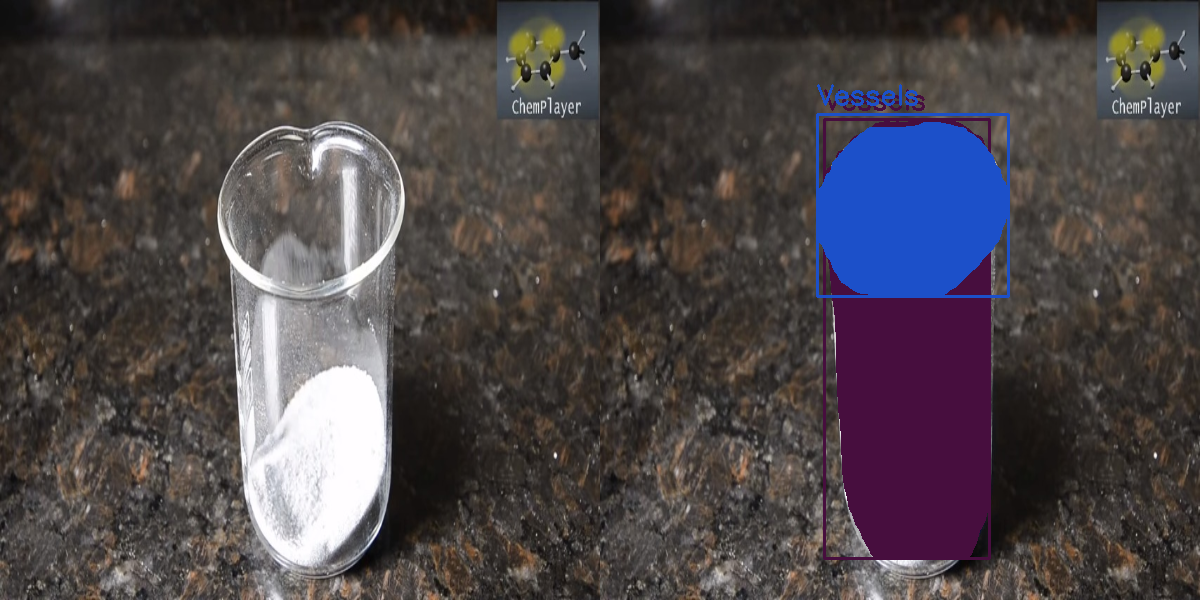

-1

In [ ]:
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
import cv2
import torchvision.models.segmentation
import torch
from google.colab.patches import cv2_imshow
imageSize=[600,600]

imgs=[]
for pth in os.listdir(trainDir):
    imgs .append(trainDir+"/"+pth +"//")
    
idx=random.randint(0,len(imgs)-1)
img = os.path.join(imgs[idx], "Image.jpg")
print(img)

imageSize=[600,600]
imgPath=img
#imgPath="/content/drive/MyDrive/Image (4).jpg"

# Define class labels
class_labels = ['background', 'Vessels']

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('gpu')   # train on the GPU or on the CPU, if a GPU is not available
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)  # load an instance segmentation model pre-trained pre-trained on COCO
in_features = model.roi_heads.box_predictor.cls_score.in_features  # get number of input features for the classifier
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes=2)  # replace the pre-trained head with a new one
model.load_state_dict(torch.load("/content/drive/MyDrive/10000.torch", map_location=torch.device('cpu')))
model.to(device)# move model to the right devic
model.eval()

images=cv2.imread(imgPath)
images = cv2.resize(images, imageSize, cv2.INTER_LINEAR)
images = torch.as_tensor(images, dtype=torch.float32).unsqueeze(0)
images=images.swapaxes(1, 3).swapaxes(2, 3)
images = list(image.to(device) for image in images)

with torch.no_grad():
    pred = model(images)

im= images[0].swapaxes(0, 2).swapaxes(0, 1).detach().cpu().numpy().astype(np.uint8)
im2 = im.copy()
for i in range(len(pred[0]['masks'])):
    msk=pred[0]['masks'][i,0].detach().cpu().numpy()
    scr=pred[0]['scores'][i].detach().cpu().numpy()
    lbl=pred[0]['labels'][i].item()
    if scr>0.8 :
        # Get the coordinates of the bounding box
        bbox = pred[0]['boxes'][i].detach().cpu().numpy()
        xmin, ymin, xmax, ymax = bbox.astype(np.int32)

        # Draw the bounding box on the image
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        thickness = 2
        cv2.rectangle(im2, (xmin, ymin), (xmax, ymax), color, thickness)

        # Draw the mask on the image
        im2[:, :, 0][msk > 0.5] = color[0]
        im2[:, :, 1][msk > 0.5] = color[1]
        im2[:, :, 2][msk > 0.5] = color[2]

        box = pred[0]['boxes'][i].detach().cpu().numpy()
        cv2.putText(im2, class_labels[lbl], (int(box[0]), int(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
cv2_imshow(np.hstack([im, im2]))
cv2.waitKey()

/content/drive/Othercomputers/My MacBook Pro/LabPics Chemistry/Test/978Eval//Image.jpg


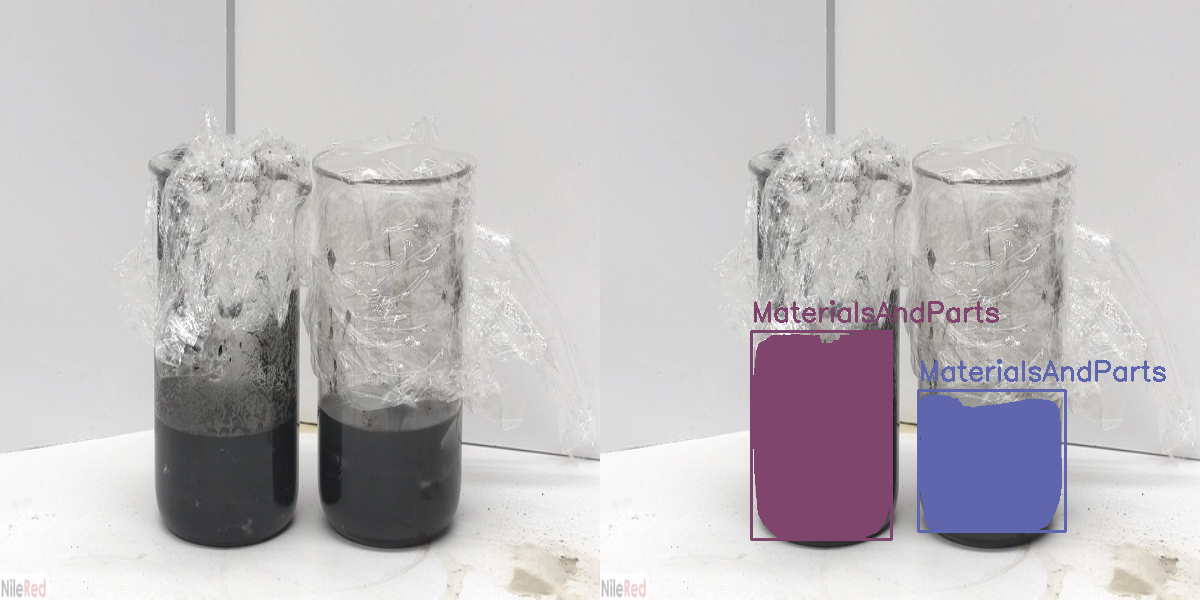

-1

In [12]:
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
import cv2
import torchvision.models.segmentation
import torch
from google.colab.patches import cv2_imshow


imageSize=[600,600]
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('gpu')   # train on the GPU or on the CPU, if a GPU is not available
trainDir='/content/drive/Othercomputers/My MacBook Pro/LabPics Chemistry/Test'

imgs=[]
for pth in os.listdir(trainDir):
    imgs .append(trainDir+"/"+pth +"//")
    
idx=random.randint(0,len(imgs)-1)
img = os.path.join(imgs[idx], "Image.jpg")
print(img)

imageSize=[600,600]
imgPath=img

#imgPath = "/content/drive/Othercomputers/My MacBook Pro/LabPics Chemistry/Test/1147Eval//Image.jpg"

# Define class labels
class_labels = ['background', 'MaterialsAndParts']

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('gpu')   # train on the GPU or on the CPU, if a GPU is not available
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)  # load an instance segmentation model pre-trained pre-trained on COCO
in_features = model.roi_heads.box_predictor.cls_score.in_features  # get number of input features for the classifier
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes=2)  # replace the pre-trained head with a new one
model.load_state_dict(torch.load("/content/10000mat.torch", map_location=torch.device('cpu')))
model.to(device)# move model to the right device
model.eval()

images=cv2.imread(imgPath)
images = cv2.resize(images, imageSize, cv2.INTER_LINEAR)
images = torch.as_tensor(images, dtype=torch.float32).unsqueeze(0)
images=images.swapaxes(1, 3).swapaxes(2, 3)
images = list(image.to(device) for image in images)

with torch.no_grad():
    pred = model(images)

im= images[0].swapaxes(0, 2).swapaxes(0, 1).detach().cpu().numpy().astype(np.uint8)
im2 = im.copy()
for i in range(len(pred[0]['masks'])):
    msk=pred[0]['masks'][i,0].detach().cpu().numpy()
    scr=pred[0]['scores'][i].detach().cpu().numpy()
    lbl=pred[0]['labels'][i].item()
    if scr>0.8 :
        # Get the coordinates of the bounding box
        bbox = pred[0]['boxes'][i].detach().cpu().numpy()
        xmin, ymin, xmax, ymax = bbox.astype(np.int32)

        # Draw the bounding box on the image
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        thickness = 2
        cv2.rectangle(im2, (xmin, ymin), (xmax, ymax), color, thickness)

        # Draw the mask on the image
        im2[:, :, 0][msk > 0.5] = color[0]
        im2[:, :, 1][msk > 0.5] = color[1]
        im2[:, :, 2][msk > 0.5] = color[2]

        box = pred[0]['boxes'][i].detach().cpu().numpy()
        cv2.putText(im2, class_labels[lbl], (int(box[0]), int(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
cv2_imshow(np.hstack([im, im2]))
cv2.waitKey()